# Documentation

> Documentation of the functions used in building the OOD Metric Class

Visual overview of how the pipeline looks like. 

```{mermaid}
flowchart LR
  A[Feature\nEmbeddings] --> C{OOD Detection}
  B[In Distribution\nLabels] --> C
  C --> F[Uncertainty Score]
  F --> D[Out of Distribtuion]
  F --> E[In Distribtuion]
```

In [ ]:
#| default_exp core

In [ ]:
#| hide
import matplotlib.pyplot as plt

from fastcore.test import *
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE

In [ ]:
#| export
import numpy as np

from fastcore.utils import *
from tqdm import tqdm

## Utility Functions

In [ ]:
#| export
def compute_mean_and_covariance(
    embdedding: np.ndarray, # (n_sample, n_dim) n_sample - sample size of training set, n_dim - dimension of the embedding
    labels: np.ndarray, # (n_sample, ) n_sample - sample size of training set
) -> Tuple[np.ndarray, np.ndarray]: # Mean of dimension (n_dim, ) and Covariance matrix of dimension(n_dim, n_dim)
    """Computes class-specific means and a shared covariance matrix.
    """
    
    n_dim = embdedding.shape[1]
    class_ids = np.unique(labels)
    
    covariance = np.zeros((n_dim, n_dim)) 
    means = []

    def f(covariance, class_id):
        mask = np.expand_dims(labels == class_id, axis=-1) # to compute mean/variance use only those which belong to current class_id
        data = embdedding * mask
        mean = np.sum(data, axis=0) / np.sum(mask)
        diff = (data - mean) * mask
        covariance += np.matmul(diff.T, diff)
        return covariance, mean

    for class_id in class_ids:
        covariance, mean = f(covariance, class_id)
        means.append(mean)
        
    covariance = covariance / len(labels)
    return np.stack(means), covariance

In [ ]:
#| export
def compute_mahalanobis_distance(
    embdedding: np.ndarray, # Embdedding of dimension (n_sample, n_dim)
    means: np.ndarray, # A matrix of size (num_classes, n_dim), where the ith row corresponds to the mean of the fitted Gaussian distribution for the i-th class.
    covariance: np.ndarray # The shared covariance matrix of the size (n_dim, n_dim)
) -> np.ndarray: # A matrix of size (n_sample, n_class) where the (i, j) element corresponds to the Mahalanobis distance between i-th sample to the j-th class Gaussian.
    """Computes Mahalanobis distance between the input and the fitted Guassians. The Mahalanobis distance (Mahalanobis, 1936) is defined as

    $$distance(x, mu, sigma) = sqrt((x-\mu)^T \sigma^{-1} (x-\mu))$$

    where `x` is a vector, `mu` is the mean vector for a Gaussian, and `sigma` is
    the covariance matrix. We compute the distance for all examples in `embdedding`,
    and across all classes in `means`.

    Note that this function technically computes the squared Mahalanobis distance
    """
    
    covariance_inv = np.linalg.pinv(covariance)
    maha_distances = []

    def maha_dist(x, mean):
        # NOTE: This computes the squared Mahalanobis distance.
        diff = x - mean
        return np.einsum("i, ij, j->", diff, covariance_inv, diff)

    for x in tqdm(embdedding):
        arr = []
        for mean in means:
            arr.append(maha_dist(x, mean))
        arr = np.stack(arr)
        maha_distances.append(arr)

    return np.stack(maha_distances)

## OOD Metric Computation Class

In [ ]:
#| export
class OODMetric:
    """OOD Metric Class that calculates the OOD scores for a batch of input embeddings.
    Initialises the class by fitting the class conditional gaussian using training data
    and the class independent gaussian using training data.
    """

    def __init__(self,
                 train_embdedding: np.ndarray, # An array of size (n_sample, n_dim) where n_sample is the sample size of training set, n_dim is the dimension of the embedding.
                 train_labels: np.ndarray # An array of size (n_train_sample, )
                ):
        self.means, self.covariance = compute_mean_and_covariance(train_embdedding, train_labels)
        self.means_bg, self.covariance_bg = compute_mean_and_covariance(train_embdedding, np.zeros_like(train_labels))

In [ ]:
#| export
@patch
def compute_rmd(
    self:OODMetric,
    embdedding: np.ndarray # An array of size (n_sample, n_dim), where n_sample is the sample size of the test set, and n_dim is the size of the embeddings.
) -> np.ndarray:  # An array of size (n_sample, ) where the ith element corresponds to the ood score of the ith data point.
    """This function computes the OOD score using the mahalanobis distance
    """
    print("Computing RMD using the computed mean and covariance")
    distances = compute_mahalanobis_distance(embdedding, self.means, self.covariance)
    print("Computing RMD using the background mean and covariance")
    distances_bg = compute_mahalanobis_distance(embdedding, self.means_bg, self.covariance_bg)

    rmaha_distances = np.min(distances, axis=-1) - distances_bg[:, 0]
    return rmaha_distances

## Example

Here is an example where we generate 500 samples having a 2048 dimensional embedding belonging to 5 clusters. Using the samples from cluster number 5 as test embeddings and rest used as train embeddings

In [ ]:
n_samples = 1000
n_centers = 10
n_features = 1024

x, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_centers, random_state=0)

In [ ]:
train_embedding = x[np.where(y < (n_centers - 5))]
train_labels = y[np.where(y < (n_centers - 5))]

test_embedding = x[np.where(y >= (n_centers - 5))]
test_labels = y[np.where(y >= (n_centers - 5))]

/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<matplotlib.collections.PathCollection>

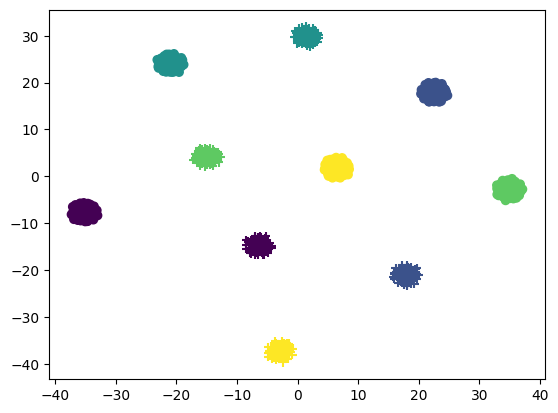

In [ ]:
#| filter_stream warnings.warn FutureWarning
tsne = TSNE(n_components=2).fit_transform(x)

x_train_tsne = tsne[np.where(y < (n_centers - 5))]
x_test_tsne = tsne[np.where(y >= (n_centers - 5))]

plt.scatter(x_train_tsne[:, 0], x_train_tsne[:, 1], marker="o", c=train_labels)
plt.scatter(x_test_tsne[:, 0], x_test_tsne[:, 1], marker="+", c=test_labels)

In [ ]:
test_eq(type(train_embedding), np.ndarray) # check that embeddings are a numpy array
test_eq(type(train_labels), np.ndarray) # check that labels are numpy array
test_eq(train_labels.dtype, int) # check that labels are integers only
test_eq(train_labels.ndim, 1) # check that labels is one dimensional
test_eq(train_embedding.shape[0], train_labels.shape[0]) # check n_samples are same

In [ ]:
ood = OODMetric(train_embedding, train_labels)

In [ ]:
test_eq(ood.means.shape[0], len(np.unique(train_labels))) # for each unique class, we should get one mean embedding
test_eq(ood.means.shape[1], train_embedding.shape[1]) # size of mean vector should be the same of the size of embedding

test_eq(ood.covariance.shape[0], train_embedding.shape[1]) # covariance matrix should be of size n_dim, n_dim
test_eq(ood.covariance.shape[1], train_embedding.shape[1])

test_eq(ood.means_bg.shape[0], 1)
test_eq(ood.means_bg.shape[1], train_embedding.shape[1])

test_eq(ood.covariance_bg.shape[0], train_embedding.shape[1])
test_eq(ood.covariance_bg.shape[1], train_embedding.shape[1])

In [ ]:
#| output: false
# testing on the train embedding itself
in_distribution_rmd = ood.compute_rmd(train_embedding)

Computing RMD using the computed mean and covariance


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 92.69it/s]


Computing RMD using the background mean and covariance


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 460.91it/s]


In [ ]:
#| output: false
ood_rmd = ood.compute_rmd(test_embedding)

Computing RMD using the computed mean and covariance


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 95.76it/s]


Computing RMD using the background mean and covariance


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 464.13it/s]


By looking at the scores, we can get an idea of setting the threshold for classifying any datapoint as out of distribution. Below histogram shows a clear idea of what OOD Relative Mahalanobis distance look like.

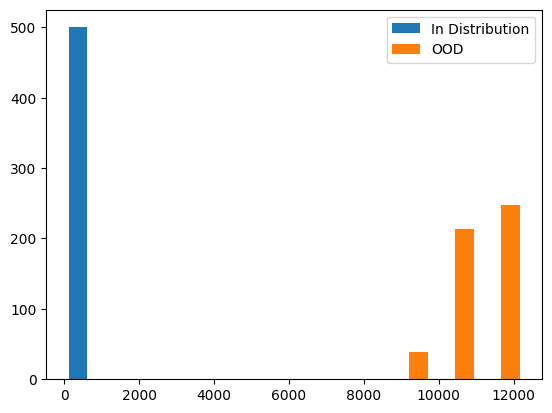

In [ ]:
plt.hist([in_distribution_rmd, ood_rmd], label=["In Distribution", "OOD"])
plt.legend()
plt.show()

In [ ]:
test_eq(ood_rmd.shape[0], test_embedding.shape[0])
test_eq(ood_rmd.ndim, 1)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()